---

# ClusterAI 2021

# Ciencia de Datos - Ingeniería Industrial - UTN BA

# clase_12: Practica Redes Neuronales Recurrentes - NLP - Sentiment Analisys

### Elaborado por: Aguirre Nicolas

Imagenes: https://guide.allennlp.org/

---

El objetivo de esta notebook es clasificar el *sentimiento* (Positivo, Negativo o Neutral) de un dataset de criticas/reviews sobre aplicaciones del Google Play Store.

Para lograr ésto, nuestro modelo tiene que ser capaz de "interpretar" el contenido de un texto, el cual puede ser descompuesto en:

  * Letras / Caracteres
  * Palabras 
  * Frases, 
  * etc.

Esto representa un primer desafio: como y cuales seran los inputs ($X_t$) que ingrese al modelo?. Este punto es el que discutiremos con la tecnica llamada *Tokenization*. 

El problema se vuelve mas complejo cuando la *temporalidad* o el *orden* de las de los inputs (el $t$ de $X_t$) define el significado de una frase:

  * Un texto con todas sus palabras mezcladas carece de sentido, verdad? o,
  * Una negacion antes o despues de una frase puede cambiar completamente el significado de la misma (Ej: "*no recomiendo descargar esta app*" vs. "*recomiendo descargar esta app, no pierdan la oportunidad*"). 
  
Esta dependencia temporal se abordará (en este ejemplo en particular) con el uso de Redes Neuronales Recurrentes (**RNN**, de sus siglas en ingles.) 

# 1) Objetivo

![](https://guide.allennlp.org/part1/your-first-model/designing-a-model-1.svg)
## 2) Tokenization
![](https://guide.allennlp.org/part1/your-first-model/designing-a-model-2.svg)
## 3) Arquitectura
![](https://guide.allennlp.org/part1/your-first-model/designing-a-model-4.svg)
## 4) Entrenamiento
![](https://guide.allennlp.org/part1/your-first-model/designing-a-model-5.svg)

# Installs en Google Colab.

In [ ]:
# Instalamos librerias
!pip install transformers
!pip install datasets
!pip install tokenizers
!pip install gputil
!pip install psutil
!pip install humanize

# Imports

In [3]:
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)
# Datasets
import datasets
from datasets import load_dataset
#Tokenizer
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer
# Varias
import os,sys,humanize,psutil,GPUtil,gc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Metricas
from sklearn.metrics import f1_score, classification_report,confusion_matrix,accuracy_score
from scipy.special import softmax
# Barra de Progreso
from tqdm.autonotebook import tqdm , trange

1.10.0+cu111
cuda


In [4]:
# Fucion para printear el uso RAM / GPU 
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

In [ ]:
# Para ver el reporte de la GPU que nos toco y la cantidad de RAM
torch.cuda.empty_cache()
gc.collect()
mem_report()
!nvidia-smi

In [6]:
# Montamos el Google Drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Dataset

Google Play Store:
https://www.kaggle.com/lava18/google-play-store-apps

Archivo: **googleplaystore_user_reviews.csv**



In [ ]:
root_path = "/content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Sentiment Analisys/"
google_df = pd.read_csv(root_path+"googleplaystore_user_reviews.csv")
google_df.dropna(how ='any', inplace = True)
google_df = google_df.drop_duplicates()
google_df

In [61]:
# Vamos a eliminar columnas innecesarias y renombrar las que nos sirven.
google_df = google_df.drop(columns=['Sentiment_Polarity','App','Sentiment_Subjectivity']).rename(columns={"Translated_Review": "text", "Sentiment": "label"})
google_df['text'] = google_df['text'].astype(str)
google_df

,text,label
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive
...,...,...
64222,Most ads older many agents ..not much owner po...,Positive
64223,"If photos posted portal load, fit purpose. I'm...",Positive
64226,"Dumb app, I wanted post property rent give opt...",Negative
64227,I property business got link SMS happy perform...,Positive


## Label Encoder

In [62]:
# Pasemos a codigo el label de cada sample
le = preprocessing.LabelEncoder()
google_df['label'] = le.fit_transform(google_df['label'])

In [ ]:
name_classes = []
for i_c in range(len(le.classes_)):
    cls_name = le.inverse_transform([i_c]) 
    print(i_c,cls_name[0])
    name_classes.append(cls_name[0])
name_classes

## Split

In [64]:
google_df_train,google_df_test = train_test_split(google_df,random_state=0,test_size=0.15)
google_df_train,google_df_val = train_test_split(google_df_train,random_state=0,test_size=0.15)

google_df_train.reset_index(drop=True,inplace=True)
google_df_val.reset_index(drop=True,inplace=True)
google_df_test.reset_index(drop=True,inplace=True)

To CSV

In [65]:
google_df_train.to_csv(root_path+"train.csv",index=False)
google_df_val.to_csv(root_path+"val.csv",index=False)
google_df_test.to_csv(root_path+"test.csv",index=False)

# 2) Tokenizacion

## Loading Dataset

In [66]:
# Definiremos las features de nuestro objeto "dataset" 
# de la libreria llamada "Dataset" de HuggingFace (libreria especializada en NLP)
features_ds = datasets.Features(
        {"text": datasets.Value("string"),
         "label": datasets.features.ClassLabel(names=name_classes)}
)

In [ ]:
# Cargamos los CSV en el objeto dataset (train, val, y test set).
# Tambien le pasamos las features que definimos en la celda anterior
dataset_google = load_dataset('csv', data_files={'train':root_path+"train.csv",
                                                 'val':root_path+"val.csv",
                                          'test':root_path+"test.csv"},
                             features=features_ds)

## Algoritmo/modelo de Tokenizacion

In [68]:
# Primero definimos el Algoritmo /modelo que vamos a utilizar
# En este caso particular, vamos a usar el "wordLevel". Vamos a separar el texto por espacios y signos de puntuacion.

# Debido a que luego definiremos una cantidad maxima de palabras que tendremos 
# en nuestro vocabulario, tenemos que definir tambien un token especial para 
# las palabras que queden incorporadas.
unk_token = "[UNK]"

# Creamos nuestro objeto Tokenizer, el cual le iremos incorporando funciones
# en las siguientes celdas
tokenizer_custom = Tokenizer(models.WordLevel(unk_token="[UNK]"))

## Pre-Tokenizer

La pretokenización es el acto de dividir un texto en objetos más pequeños 

In [69]:
# Pre-tokenizador:
pre_tok = pre_tokenizers.Whitespace()
tokenizer_custom.pre_tokenizer = pre_tok

## Trainer

In [70]:
# Importante: 
# 1) Cada Tokenizer tiene su trainer asociado ya que internamiente son algoritmos distintos
# 2) Al trainer le debemos pasar tambien los tokens especiales que utilicemos 

token_trainer = tokenizer_custom.model.get_trainer()
# Definimos el tamaño de nuestro vocabulario
token_trainer.vocab_size = 15000
# La cantidad minima de veces que una palabra/token tiene que aparecer para ser incorpoada
token_trainer.min_frequency = 2
# Definimos los tokens especiales que utilizaremos.
special_tokens = ["[UNK]","[PAD]","[SOS]","[EOS]"]
token_trainer.special_tokens = special_tokens

## Training

In [71]:
# Creamos una funcion que itere por batch en nuestro dataset['text']
def batch_iterator(dataset,batch_size):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i : i + batch_size]["text"]

# Stackoverflow - yield
# https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do        

In [72]:
# Nuestor tokenizer ya esta en condiciones de ser entrenado y definir que indices 
# se le asignara a cada palabra/token

batch_size_tok = 1000 # Cantidad de frases que vamos muestreando
tokenizer_custom.train_from_iterator(batch_iterator(dataset_google['train'],batch_size_tok), trainer=token_trainer)

## Post- Tokenization

### [SOS] & [EOS]

Start of Sentence & End Of Sentence

In [73]:
# Comunmente se incorporan estos tokens para que el modelo aprenda cuando una
# frase comienza y cuando una frase termina.
post_toke = processors.TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[
        ("[SOS]", 2),
        ("[EOS]", 3),
    ],
)
tokenizer_custom.post_processor = post_toke

In [74]:
encoding = tokenizer_custom.encode("what is this ?veryrareword test 123 111")
print(encoding.ids)
print(encoding.tokens)

[2, 482, 95, 127, 34, 0, 1080, 0, 0, 3]
['[SOS]', 'what', 'is', 'this', '?', 'veryrareword', 'test', '123', '111', '[EOS]']


### Padding y Truncation

In [75]:
# Para entrenar nuestros modelos en batch, la longitud de todos los textos deben ser iguales.
# Por tal motivo, vamos a hablitar "padding" y "truncation" para los textos mas cortos y largos, respectivamente.

# Definimos la longitud maxima del modelo
max_lenght = 120

# Padding: agregar datos NO-informativos para alcanzar una longitud esperada 
# en una secuencia.
tokenizer_custom.enable_padding(direction='right', # El padding es a la derecha
                                pad_id=1 ,
                                pad_to_multiple_of = max_lenght,
                                pad_token="[PAD]")
#Truncation
tokenizer_custom.enable_truncation(max_lenght,
                                   stride=0,
                                   strategy='longest_first')

encoding = tokenizer_custom.encode("what is this ?veryrareword test 123 111")
print(encoding.ids)
print(encoding.tokens)

[2, 482, 95, 127, 34, 0, 1080, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['[SOS]', 'what', 'is', 'this', '?', 'veryrareword', 'test', '123', '111', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

## Dataset Tokenization

Recien ahora, con nuestro tokenizador entrenado podremos aplicarlo a nuestro dataset!

In [76]:
# Creamos una funcion que aplicara el encode a nuestro todo el dataset y va a crear
def _tokenize(examples):
    result = {}
    for e in tokenizer_custom.encode_batch(examples['text']):
        result.setdefault('ids', []).append(e.ids)
        result.setdefault('tokens', []).append(e.tokens)
        result.setdefault('offsets', []).append(e.offsets)
        result.setdefault('special_tokens_mask', []).append(e.special_tokens_mask) # if id is special token or not
        result.setdefault('text_lenght', []).append(np.sum(np.array(e.special_tokens_mask)==0)+2)
    return result

In [ ]:
dataset_google = dataset_google.map(_tokenize, batched=True,batch_size=5000)

## Ejemplo

In [86]:
idx_rnd = np.random.randint(0,len(dataset_google['train']))
idx_rnd = dataset_google['train'][idx_rnd]
print(name_classes[idx_rnd['label']],'\r\n')
print(idx_rnd['text'],'\r\n')
print(idx_rnd['tokens'],'\r\n')
print(idx_rnd['ids'],'\r\n')
print(idx_rnd['special_tokens_mask'],'\r\n')
print(idx_rnd['label'],'\r\n')
print(idx_rnd['text_lenght'],'\r\n')
np.sum(np.array(idx_rnd['special_tokens_mask'])==0)+2

Negative 

The works warning. If AA delayed. I taken trip AA atleast 2 lengthy delays trip. They pretty terrible getting want go say will. 

['[SOS]', 'The', 'works', 'warning', '.', 'If', 'AA', 'delayed', '.', 'I', 'taken', 'trip', 'AA', 'atleast', '2', 'lengthy', 'delays', 'trip', '.', 'They', 'pretty', 'terrible', 'getting', 'want', 'go', 'say', 'will', '.', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

29

## Guardamos el tokenizador

In [27]:
tokenizer_custom.save(root_path+"google_tokenizer.json",pretty=True)

### Import

In [28]:
"""tokenizer_custom = Tokenizer.from_file(root_path+"google_tokenizer.json")"""

'tokenizer_custom = Tokenizer.from_file(root_path+"google_tokenizer.json")'

Hasta aqui terminamos con la Tokenization ...

En el siguiente link podran encontrar los distintos algoritmos de tokenization y la forma de aplicarlos para otros casos de NLP.

[Documentacion HuggingFace](https://huggingface.co/docs/tokenizers/python/latest/pipeline.html)

# Formato a PyTorch

A cada uno de los subset los pasamos a formato pytorch, y le indicamos que columnas queremos (opcional indicarle tambien el dispositivo, en este caso, cuda=GPU)

In [30]:
train_ds = dataset_google['train']
val_ds = dataset_google['val']
test_ds = dataset_google['test']

train_ds.set_format('torch', columns=['ids', 'label', 'text_lenght'], device='cuda')
val_ds.set_format('torch', columns=['ids', 'label', 'text_lenght'], device='cuda')
test_ds.set_format('torch', columns=['ids', 'label','text_lenght'], device='cuda')

# Dataloader

In [31]:
# Definimos el batch size
bs = 64
# Definimos los dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = bs, shuffle = True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = bs*2, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = bs*2, shuffle = True)

In [32]:
# Los dataloaderes pueden ser iterados, asi que le pedimos un elemento con 'next'
# simplemente para ver un ejemplo.
next(iter(test_dl))

{'ids': tensor([[   2,    5,   71,  ...,    1,    1,    1],
         [   2,    5,  191,  ...,    1,    1,    1],
         [   2,   47,  111,  ...,    1,    1,    1],
         ...,
         [   2,    0, 8925,  ...,    1,    1,    1],
         [   2,   82,    3,  ...,    1,    1,    1],
         [   2,  220,   29,  ...,    1,    1,    1]], device='cuda:0'),
 'label': tensor([0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 2,
         2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0,
         2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 0,
         2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 0,
         1, 0, 2, 2, 2, 0, 1, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0,
         2, 2, 0, 2, 2, 2, 2, 2], device='cuda:0'),
 'text_lenght': tensor([ 34,  45,  34,   3,  25,  19,  32,   9,  11,  17,  26,  29,  35,  22,
          27,  12,  20,   6,  25,  14,  11,   3,  18,   6,   5,  28,  13,  32,
   

# 3) Modelo

![](https://guide.allennlp.org/part1/your-first-model/designing-a-model-4.svg)

## Arquitectura

### Configuracion

Vamos a definir un conjunto de variables auxiliares que, como veremos en las siguientes celdas, vamos a necesitar para definir la arquitectura de nuestro modelo.

Lo que buscamos hacer es tener un codigo donde:

```
# modelo = Arquitectura (variables_de_configuracion)
```

In [34]:
# Vocab Size ---> Para el Embedding
vocab_size = tokenizer_custom.get_vocab_size()
# El indice del embedding que corresponde al padding
pad_id = tokenizer_custom.token_to_id("[PAD]")
# Diumensiones del embedding
emb_dim = 150
# Si queremos que nuestra capa RNN/GRU sea bidireccional
bidirectional = True
# Dimensiones de Entrada y Saluda de nuestra capa recurrente
rnn_dim = [emb_dim, 256]
# Numero de capas RNN
num_layers = 2
# Numero de clases --> Para la capa de salida
n_classes = len(name_classes)
# % de Droput para regularizar
dropout = 0.25

# Por comodidad le vamos a pasar todos estos
# parametros de config en un diccionario
args = {
    'vocab_size' : vocab_size,
    'pad_id' : pad_id,
    'embedding_dim' : emb_dim,
    'n_classes' : n_classes,
    'rnn1_dim' : rnn_dim,
    'bidirectional' : bidirectional,
    'num_layers': num_layers,
    'dropout': dropout
}
args

{'bidirectional': True,
 'dropout': 0.25,
 'embedding_dim': 150,
 'n_classes': 3,
 'num_layers': 2,
 'pad_id': 1,
 'rnn1_dim': [150, 256],
 'vocab_size': 12042}

### Definicion

In [33]:
class SentimentAnalisys(nn.Module):
  def __init__(self,args):
    super(SentimentAnalisys, self).__init__()
    """
     Se llama la funcion __init__ al momento que creemos el objeto y respondemos
     a la pregunta:

     'Que partes componen al modelo?'.
     Es decir, inicializamos todos sus parametros a aprender.
     Tambien podemos definir cualquier otro tipo de variable auxiliar dentro del modelo.


     Por otro lado, en la funcion 'forward' vamos a responder a la pregunta:

     'Como es el forward pass?. 
     Es decir, indicamos que camino va a recorrer la informacion por las
     partes del modelo que previamente inicializamos.

     #Datazo:
     Estrictamente hablando, tanto las partes del modelo de NN como las 
     variables auxiliares se llaman "atributos", y las definimos usando el 
     prefijo "self.nombre_de_variable", mientras que las funciones que definimos
     llaman "metodos".  
    """

    ###########################
    # Var. Auxiliares: Inicio
    ###########################
    # Guardamos variables propias del modelo para usar luego.
    self.vocab_size = args['vocab_size']
    # el token ID del padding
    self.pad_id = args['pad_id']
    # El tamaño del embedding
    self.embedding_dim = args['embedding_dim']
    # La cantidad de labels
    self.n_classes = args['n_classes']
    # la cantidad de hidden dimension de la RNN
    self.rnn1_dim = args['rnn1_dim']
    # Si vamos a usar bidericcionalidad
    self.bidirectional = args['bidirectional']
    # Cantidad de capas RNN
    self.num_layers = args['num_layers']
    # Si es bidirectional, entonces entrada a la capa fully conected (nn.Linear)
    # es el doble de grande
    self.num_directions = 2 if self.bidirectional  == True else 1
    ###########################
    # Variables Auxiliares: Fin
    ###########################    

    ###########################
    # Partes del modelo: Inicio
    ###########################
    # 1) Definamos el embedding
    self.embedding = nn.Embedding(num_embeddings = self.vocab_size,
                                  embedding_dim = self.embedding_dim ,
                                  padding_idx = self.pad_id )
    # 2) Definimos una RNN (GRU)
    self.rnn1 = nn.GRU(input_size = self.rnn1_dim[0],
                       hidden_size = self.rnn1_dim[1],
                       num_layers = self.num_layers,
                       bidirectional = self.bidirectional,
                       batch_first = True )
    # 3)
    # Si el modelo tiene dos direcciones, el temaño de la ultima layer se duplica!
    self.linear_dim = [self.rnn1_dim[1]*self.num_directions,self.n_classes]
    # Definimos una capa fully-conected de salida    
    self.linear = nn.Linear(in_features = self.linear_dim[0],
                            out_features = self.linear_dim[1])
    # Definimos una capa de droput para regularizar
    self.do = nn.Dropout(args['dropout'])

    ###########################
    # Partes del modelo: Fin
    ###########################    

  def forward(self,x,text_lengths):
    
    # 1) Capa Embedding
    output = self.embedding(x)
    
    # Pack_Packed:
    # Esta capa la hacemos simplemente para cortar el forward/backward pass
    # en los indices cuyo id == 'PAD'.
    # Doc:
    # https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html
    packed_embedded = nn.utils.rnn.pack_padded_sequence(
        output, text_lengths.to('cpu'),
        batch_first=True, enforce_sorted=False)

    # 2) Capa Recurrente
    packed_output, h_n = self.rnn1(packed_embedded) 
    # Doc:
    # https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    
    #################
    ## Bidirectional: 
    #################
    # Doc: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
    # h_n = [num layers * num directions, batch size, hid dim]
    # concatenamos el hidden_state final:
    # * forward RNN: h_n[-2,:,:] 
    # * backward RNN: h_n[-1,:,:]
    if self.bidirectional:
      h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim = 1)    
    
    # 3) Aplicamos dropout y la capa fully-conected.
    output = self.linear(self.do(h_n))
    return output

### Creacion

In [35]:
# Definamos el modelo, y pasemoslo a la GPU ('cuda')
modelo = SentimentAnalisys(args).to('cuda')

## Optimizador y Loss Function

In [36]:
#################
# Optimizador
#################
# Learning rate
learning_rate = 0.001
optimizer = Adam(modelo.parameters(),
                 lr = learning_rate,
                 weight_decay = 0.005) # Regularizacion


#################
# Loss Function
#################
# Debido a que nuestro dataset se encuentra desbalanceado,
# vamos a pasar un tensor indicadole como ponderaremos la loss function.
# 0.9: Negative , 1: Neutral, 0.3: Positive
class_weights = torch.FloatTensor([0.9,1,0.3]).to(device)
# Definimos la loss function y le pasamos los pesos!
loss_function = nn.CrossEntropyLoss(weight=class_weights)

In [37]:
# Vamos a generarnos un diccionario donde iremos guardando los resultados
# del entrenamiento
history = {'train':{'loss':[],'acc': []},
           'val':{'loss': [],'acc': []}}

# Training

![](https://drive.google.com/uc?id=1d7Rq5FsmQNWcP8T1KGi_TodL49jCEKnY)

![](https://guide.allennlp.org/part1/your-first-model/designing-a-model-5.svg)

In [38]:
# Definimos la cantidad de epochs a entrenar
epochs = 50
# Cantidad de muestras que hay en cada dataset,
# Esto lo necesitamos para que la comparacion de la loss de entrenamiento y validacion
# sea valida
normalizer_train = len(train_dl.dataset)
normalizer_val = len(val_dl.dataset)
normalizer_test = len(test_dl.dataset)

In [ ]:
# Vamos a crear 4 variables para ir haciendo seguimiento de la loss
# y del accuracy duante cada epoc
epoch_loss_train = 0
epoch_loss_val = 0
accuracy_train = 0 
accuracy_val = 0

pbar1 = tqdm(range(epochs),unit=" epoch")
for epoch in pbar1:
  # Aqui creamos la barra y configuramos que mensajes queremos que aparezcan
  # durante el entrenamiento
  pbar1.set_postfix({
      'Loss_t': epoch_loss_train,
      'Acc_t': accuracy_train,
      'Loss_v':epoch_loss_val,
      'Acc_v': accuracy_val})
  
  # Reseteamos las variables debido al for loop
  epoch_loss_train , epoch_loss_val = 0, 0
  accuracy_train , accuracy_val = 0, 0 
  ###############################  
  # TRAINING   
  ###############################
  with tqdm(total=len(train_dl)+len(val_dl), unit=" batch",leave=False) as pbar2:
    # Cantidad de labels acertados  
    correct = 0
    # Pasamos el modelo a modo 'train' (activa los dropout/batchnorm)
    modelo.train()
    # Para cada batch del dataloader
    for batch in train_dl:
      # Actualizamos el contador de batches de la barra de progreso
      pbar2.update(1)
      # x: nuestros ids
      x = batch['ids']
      x_l = batch['text_lenght']
      # y_true: el label correcto
      y_true = batch['label']
      # Limpiamos los gradientes que observa el optimizador
      # si no lo hacemos, se van a ir acumulando y es incorrecto
      optimizer.zero_grad()
      # Generamos una prediccion
      y_hat = modelo(x,x_l)
      # Calculamos la loss w.r.t el true value
      loss = loss_function(y_hat,y_true)
      # Calculamos los gradientes del modelo w.r.t la loss
      loss.backward()
      # Aplicamos los gradientes
      optimizer.step()
      # Obtenemos el label predicho
      _, predicted = torch.max(y_hat.data, 1)
      # Acumulamos la loss
      epoch_loss_train += loss.item()
      # Cantidad de labels correctamente predichos
      correct_i = (predicted == y_true).sum().item() 
      correct += correct_i
      pbar2.set_postfix({
              'Loss_t:': loss.item() / x.size()[0],
              'Acc_t': correct_i / (x.size()[0])})      

    # una vez que termina una epoch de training, normalizamos loss y acc
    # por la cantidad de samples que habia en el set de entrenamiento
    epoch_loss_train = epoch_loss_train / normalizer_train
    accuracy_train = 100 * correct / normalizer_train

    ###############################  
    # Validation   
    ###############################
    # Desactivamos los dropout/batch_norm
    modelo.eval()
    # volvemos a inicializar el contador para el accuracy
    correct = 0
    # Como ahora estamos testeando, no necesitamos computar gradiente
    # (desactiva funciones y operaciones sobre el grafo computacional)
    with torch.inference_mode():
      for batch in val_dl:
        pbar2.update(1)
        x = batch['ids']
        x_l = batch['text_lenght']
        y_true = batch['label']
        y_hat = modelo(x,x_l)
        val_loss = loss_function(y_hat,y_true)
        _, predicted = torch.max(y_hat.data, 1)
        correct += (predicted == y_true).sum().item()
        epoch_loss_val += val_loss.item()

    #Estimamos la loss y el acc w.r.t el set de testeo
    epoch_loss_val = epoch_loss_val / normalizer_val
    accuracy_val = 100 * correct / normalizer_val

    # Actualizamos nuestro historial
    history['train']['loss'].append(epoch_loss_train)
    history['val']['loss'].append( epoch_loss_val)
    history['train']['acc'].append(accuracy_train)
    history['val']['acc'].append(accuracy_val)  

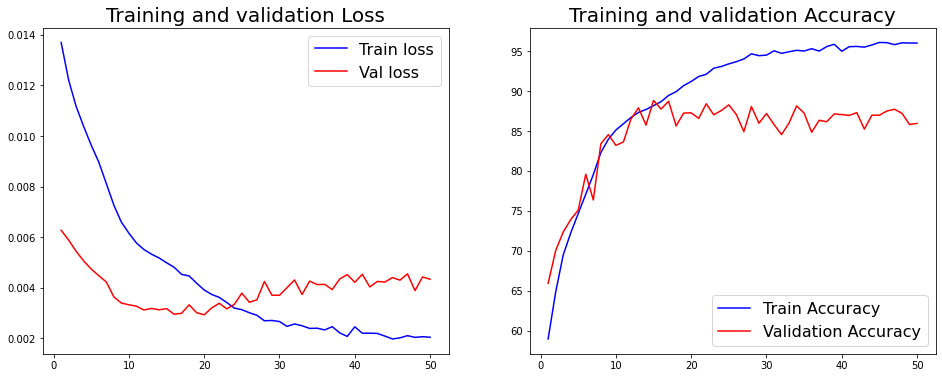

In [45]:
#Loss
train_loss_h = history['train']['loss']
val_loss_h = history['val']['loss']
# Acc
train_acc_h = history['train']['acc']
val_acc_h = history['val']['acc']
lepochs = range(1, len(train_loss_h) + 1)
# Plot
fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(lepochs, train_loss_h, 'b', label='Train loss')
axs[0].plot(lepochs, val_loss_h, 'r', label='Val loss')
axs[0].set_title('Training and validation Loss',fontsize=20)
axs[0].legend(fontsize=16)
axs[1].plot(lepochs, train_acc_h, 'b', label='Train Accuracy')
axs[1].plot(lepochs, val_acc_h, 'r', label='Validation Accuracy')
axs[1].set_title('Training and validation Accuracy',fontsize=20)
axs[1].legend(fontsize=16)
plt.show()

## Save and load

In [ ]:
#torch.save(modelo.state_dict(), root_path+'Sentyment_model.pt')
modelo = SentimentAnalisys(args).to('cuda')
modelo.load_state_dict(torch.load(root_path+'Sentyment_model.pt'))
modelo.eval()

## Ejemplos

**Propongan por el chat ejemplos de criticas de aplicaciones en ingles y veamos los resultados.**

In [46]:
text_proposed = "PROPUESTAS_DEL_CHAT"
input_test = tokenizer_custom.encode(text_proposed)
input_lenght = [np.sum(np.array(input_test.special_tokens_mask)==0)+2]
input_lenght = torch.LongTensor(input_lenght)
input_test = torch.LongTensor(input_test.ids).to(device).unsqueeze(0)
prediction = modelo(input_test,input_lenght).to('cpu')
prediction_prob = softmax(prediction.detach().numpy())[0]
prediction_id = np.flip(np.argsort(prediction_prob))
pd.DataFrame({'Class': np.array(name_classes)[prediction_id],
              'Probability' : prediction_prob[prediction_id]*100})

,Class,Probability
0,Neutral,88.572685
1,Positive,5.794253
2,Negative,5.633056


**Veamos ejemplos aleatorios del dataset de testeo**

In [54]:
rnd_idx = np.random.randint(len(test_ds))
print(tokenizer_custom.decode(test_ds[rnd_idx]['ids'].to('cpu').numpy()))

I took CDL today passed knowledge , air , combination issues ! Only used study ! I highly recommend anyone ! Good job , creators !


In [55]:
print(name_classes[test_ds[rnd_idx]['label']])
input_test = test_ds[rnd_idx]['ids'].unsqueeze(0)
input_lenght = test_ds[rnd_idx]['text_lenght'].unsqueeze(0)
prediction = modelo(input_test,input_lenght).to('cpu')
prediction_prob = softmax(prediction.detach().numpy())[0]
prediction_id = np.flip(np.argsort(prediction_prob))
pd.DataFrame({'Class': np.array(name_classes)[prediction_id],
              'Probability' : prediction_prob[prediction_id]*100})

Positive


,Class,Probability
0,Positive,99.984787
1,Negative,0.009753
2,Neutral,0.005458


# Evaluation

Creamos una funcion para que evalua sobbre el test set.

In [56]:
def evaluate(modelo,dataloader):
    # Modelo en modo evaluation
    # Desactiva el dropout
    modelo.eval()
    # Variables donde guardar resultados
    test_loss_total = 0
    y_pred, y_true = [], []
    correct = 0
    with torch.inference_mode():        
      for batch in tqdm(dataloader):
        x = batch['ids']
        x_l = batch['text_lenght']
        y = batch['label']
        y_hat = modelo(x,x_l)
        loss = loss_function(y_hat,y)
        test_loss_total += loss.item()
        _, predicted = torch.max(y_hat.data, 1)
        predicted = predicted.detach().cpu().numpy()
        label_ids = y.cpu().numpy()
        y_pred.append(predicted)
        y_true.append(label_ids)
    
    test_loss = test_loss_total/len(dataloader) 
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
            
    return test_loss, y_pred, y_true

In [57]:
test_loss, y_pred, y_true = evaluate(modelo,test_dl)

  0%|          | 0/35 [00:00<?, ?it/s]

## Confusion Matrix

0.8590031432420296


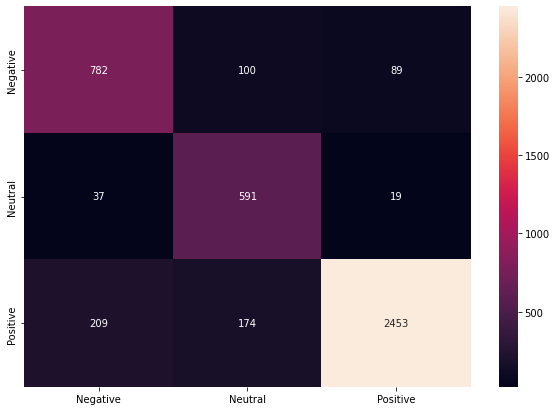

In [58]:
con_mat = confusion_matrix(y_true,y_pred)
acc_test = accuracy_score(y_true,y_pred)
print(acc_test)

df_cm = pd.DataFrame(con_mat, index = [i for i in name_classes],
                  columns = [i for i in name_classes])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt='g')
plt.show()

# Preguntas?

![](https://preview.redd.it/t87gswsbmnq41.jpg?width=640&crop=smart&auto=webp&s=b2777564c452e6de90edd14ef57b8740632da573)